In [1]:
import librosa
import librosa.feature
import librosa.display
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils.np_utils import to_categorical

#Using TensoFlow backend.

Using TensorFlow backend.
d:\dev\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\dev\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\dev\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\dev\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:526: Fu

In [5]:
def display_mfcc(song):
    y, _ = librosa.load(song)
    mfcc = librosa.feature.mfcc(y)
    
    plt.figure(figsize=(10,4))
    librosa.display.specshow(mfcc, x_axis='time', y_axis='mel')
    plt.colorbar()
    plt.title(song)
    plt.tight_layout()
    plt.show()

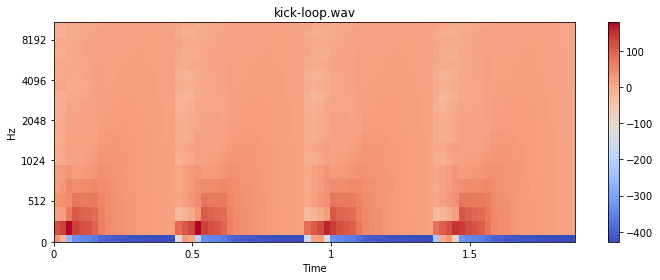

In [9]:
display_mfcc('kick-loop.wav')

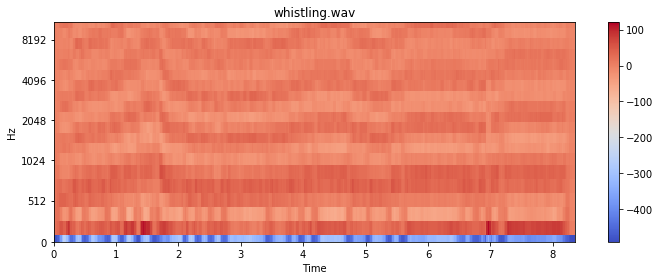

In [12]:
display_mfcc('whistling.wav')

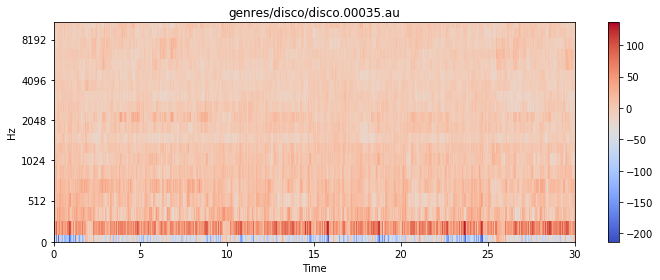

In [13]:
display_mfcc('genres/disco/disco.00035.au')

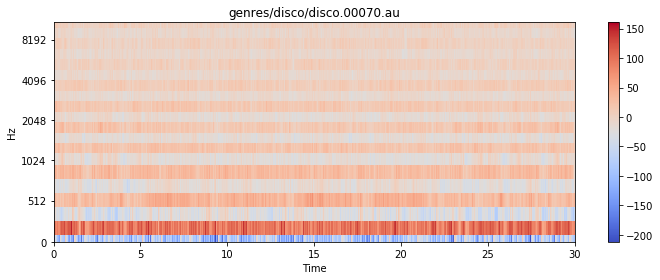

In [14]:
display_mfcc('genres/disco/disco.00070.au')

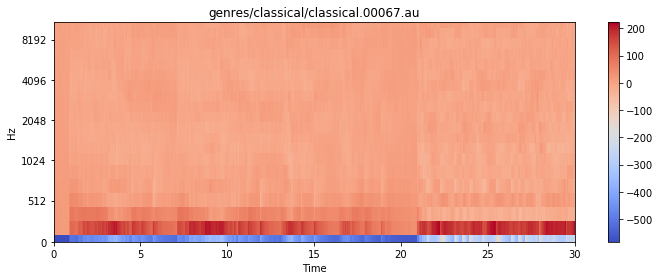

In [15]:
display_mfcc('genres/classical/classical.00067.au')

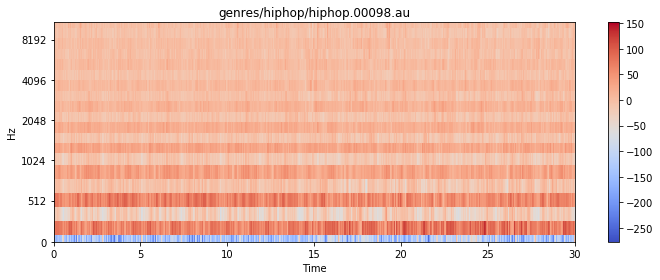

In [16]:
display_mfcc('genres/hiphop/hiphop.00098.au')

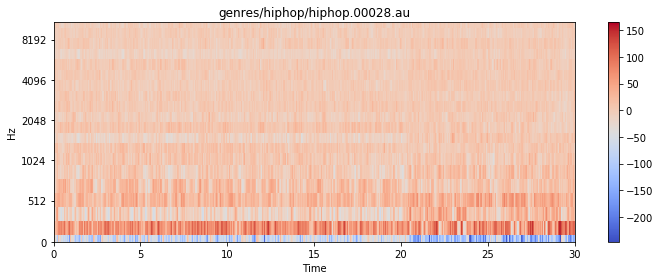

In [17]:
display_mfcc('genres/hiphop/hiphop.00028.au')

In [2]:
def extract_features_song(f):
    y, _=librosa.load(f)
    # get Mel-frequency cepstral  coefficients
    mfcc = librosa.feature.mfcc(y)
    # normalize values between -1, 1 (divide by max)
    mfcc /= np.amax(np.absolute(mfcc))
    
    return np.ndarray.flatten(mfcc)[:25000]

In [3]:
def generate_features_and_labels():
    all_features = []
    all_labels = []
    
    genres = ['blues', 'classical', 'country', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
    for genre in genres:
        sound_files = glob.glob('genres/'+genre+'/*.au')
        print('Processing %d songs in %s genre...' % (len(sound_files), genre))
        for f in sound_files:
            features = extract_features_song(f)
            all_features.append(features)
            all_labels.append(genre)
            
    # convert labels to one-hot encoding
    label_uniq_ids, label_row_ids = np.unique(all_labels, return_inverse=True)
    label_row_ids = label_row_ids.astype(np.int32, copy=False)
    onehot_labels = to_categorical(label_row_ids, len(label_uniq_ids))
    return np.stack(all_features), onehot_labels

In [4]:
features, labels = generate_features_and_labels()

Processing 100 songs in blues genre...
Processing 100 songs in classical genre...
Processing 100 songs in country genre...
Processing 100 songs in hiphop genre...
Processing 100 songs in jazz genre...
Processing 100 songs in metal genre...
Processing 100 songs in pop genre...
Processing 100 songs in reggae genre...
Processing 100 songs in rock genre...


In [5]:
print(np.shape(features))
print(np.shape(labels))

training_split = 0.8

# last column has genres, turn it in to unique ids
alldata = np.column_stack((features, labels))

np.random.shuffle(alldata)
splitidx = int(len(alldata) * training_split)
train, test = alldata[:splitidx,:], alldata[splitidx:, :]

print(np.shape(train))
print(np.shape(test))

train_input = train[:, :-10]
train_labels = train[:,-10:]

test_input = test[:, :-10]
test_labels = test[:, -10:]

print(np.shape(train_input))
print(np.shape(train_labels))

(900, 25000)
(900, 9)
(720, 25009)
(180, 25009)
(720, 24999)
(720, 10)


In [6]:
model = Sequential([
    Dense(100, input_dim=np.shape(train_input)[1]),
    Activation('relu'),
    Dense(10),
    Activation('softmax'),
])

model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

print(model.summary())

model.fit(train_input, train_labels, validation_split=0.2, epochs=10, batch_size=32)

loss, acc = model.evaluate(test_input, test_labels, batch_size=32)

print("Done!")
print("Loss: %.4f, accuracy: %.4f" % (loss, acc))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               2500000   
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 2,501,010
Trainable params: 2,501,010
Non-trainable params: 0
_________________________________________________________________
None
Train on 576 samples, validate on 144 samples
Epoch 1/10
576/576 [==============================] - 7s 12ms/step - loss: 1.8817 - acc: 0.3281 - val_loss: 1.5044 - val_acc: 0.3681
Epoch 2/10
576/576 [==============================] - 0s 413us/step - loss: 1.14

In [7]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.utils import np_utils
from sklearn.model_selection import StratifiedKFold

In [8]:
d=pd.concat([pd.read_csv("youtube-spam/Youtube01-Psy.csv"),
             pd.read_csv("youtube-spam/Youtube02-KatyPerry.csv"),
             pd.read_csv("youtube-spam/Youtube03-LMFAO.csv"),
             pd.read_csv("youtube-spam/Youtube04-Eminem.csv"),
             pd.read_csv("youtube-spam/Youtube05-Shakira.csv")])

d = d.sample(frac=1)

In [9]:
kfold = StratifiedKFold(n_splits=5)
splits = kfold.split(d, d['CLASS'])

In [10]:
for train, test in splits:
    print("Split")
    print(test)

Split
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 

In [23]:
def train_and_test(train_idx, test_idx):
    train_content = d['CONTENT'].iloc[train_idx]
    test_content = d['CONTENT'].iloc[test_idx]
    
    tokenizer = Tokenizer(num_words=2000)
    
    # Learn the training words (not the testing words!)
    tokenizer.fit_on_texts(train_content)
    
    # options for made : binary, freq, tfidf
    d_train_inputs = tokenizer.texts_to_matrix(train_content, mode='tfidf')
    d_test_inputs = tokenizer.texts_to_matrix(test_content, mode='tfidf')
    
    # divide tfidf by max
    d_train_inputs = d_train_inputs/np.amax(np.absolute(d_train_inputs))
    d_test_inputs = d_test_inputs/np.amax(np.absolute(d_test_inputs))
    
    # substract mean, to get values between -1 and 1
    d_train_inputs = d_train_inputs - np.mean(d_train_inputs)
    d_test_inputs = d_test_inputs - np.mean(d_test_inputs)
    
    # one-hot encoding of outputs
    d_train_outputs = np_utils.to_categorical(d['CLASS'].iloc[train_idx])
    d_test_outputs = np_utils.to_categorical(d['CLASS'].iloc[test_idx])
    
    model = Sequential()
    model.add(Dense(512, input_shape=(2000,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adamax',
                 metrics=['accuracy'])
    
    model.fit(d_train_inputs, d_train_outputs, epochs=10, batch_size=16)
    scores = model.evaluate(d_test_inputs, d_test_outputs)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    return scores

In [24]:
kfold = StratifiedKFold(n_splits=5)
splits = kfold.split(d, d['CLASS'])
cvscores = []
for train_idx, test_idx in splits:
    scores = train_and_test(train_idx, test_idx)
    cvscores.append(scores[1]*100)

Epoch 1/10
1564/1564 [==============================] - 1s 857us/step - loss: 0.5809 - acc: 0.8350
Epoch 2/10
1564/1564 [==============================] - 1s 350us/step - loss: 0.3361 - acc: 0.9137
Epoch 3/10
1564/1564 [==============================] - 1s 322us/step - loss: 0.2136 - acc: 0.9425
Epoch 4/10
1564/1564 [==============================] - 1s 327us/step - loss: 0.1611 - acc: 0.9540
Epoch 5/10
1564/1564 [==============================] - 1s 333us/step - loss: 0.1317 - acc: 0.9616
Epoch 6/10
1564/1564 [==============================] - 1s 332us/step - loss: 0.1125 - acc: 0.9668
Epoch 7/10
1564/1564 [==============================] - 1s 326us/step - loss: 0.0984 - acc: 0.9725
Epoch 8/10
1564/1564 [==============================] - 1s 325us/step - loss: 0.0844 - acc: 0.9757
Epoch 9/10
1564/1564 [==============================] - 0s 311us/step - loss: 0.0785 - acc: 0.9751
Epoch 10/10
392/392 [==============================] - 0s 270us/step
acc: 96.17%
Epoch 1/10
1565/1565 [======